# Procesamiento de los datos

## Carga de los datos

In [1]:
import pandas as pd
import numpy as np

perth_49_df = pd.read_csv('WEC_Perth_49.csv', sep=',')

## Extracción de matriz de carácteristicas y target

In [2]:
def extract_features_target(df):
    '''
    Given an appropriate dataset df with the large wave farm data identifies
    the number of converters and extract the matrix of features and the target
    vector.

    Input: dataframe with the wave farm data

    Output:
    X = feauture matrix (N x 2*n_converters): coordinates of converters where
        each row represent a different layout described as
        X1, Y1, X2, Y2, ... Xn, Yn
    y = vector target (N,1): total power generated by each layout
    '''
    #Identify if the dataset corresponds to 49 or 100 converters
    if df.shape[1] == 3*49+2:
        n_converters = 49
    elif df.shape[1] == 3*100+2:
        n_converters = 100
    else:
        print('Invalid or corrupted dataset')
        return
    # Extract the geometrical information
    X = df.iloc[:, 0:2*n_converters].values
    y = df['Total_Power'].values.reshape(-1,1)

    return X, y

In [3]:
perth_49_df.iloc[:,0:49*2].head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X45,Y45,X46,Y46,X47,Y47,X48,Y48,X49,Y49
0,600.0,0.0,546.16,37.50,489.79,74.88,432.47,112.05,650.0,0.0,...,400.0,800.0,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0
1,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,400.0,800.0,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0
2,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,400.0,800.0,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0
3,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,400.0,800.0,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0
4,200.0,0.0,146.17,37.53,89.76,74.93,32.40,112.18,400.0,0.0,...,800.0,800.0,746.17,837.53,689.76,874.93,632.40,912.18,0.0,1010.0


In [4]:
X, y = extract_features_target(perth_49_df)
X

array([[ 600.  ,    0.  ,  546.16, ...,  912.05,    0.  , 1010.  ],
       [ 593.  ,   12.  ,  546.16, ...,  912.05,    0.  , 1010.  ],
       [ 593.  ,   12.  ,  546.16, ...,  912.05,    0.  , 1010.  ],
       ...,
       [ 200.  ,  100.  ,  400.  , ...,  750.  ,  650.  ,  850.  ],
       [ 500.  ,  250.  ,  350.  , ...,  350.  ,  250.  ,  800.  ],
       [ 100.  ,  400.  ,  400.  , ...,  550.  ,  750.  ,  250.  ]])

In [5]:
y

array([[4102461.43],
       [4103361.41],
       [4103680.44],
       ...,
       [4048053.62],
       [4062515.64],
       [4057544.99]])

## Transformación de matriz de carácteristicas

### Grid (image)

In [6]:
def generate_grid(X, gamma=50, size=80):
    '''
    Transforms the matrix of features into a new matrix where each row corresponds
    to a grid representing the geometrical characterists of the layout as
    a picture of size x size pixels in a flattened vector version. Each pixel assigns a
    value corresponding to the summation of a gaussian kernel with parameter gamma
    using the euclidean distances between the equivalent centroid of the pixel
    and the location of each converter

    Input: X = feauture matrix (N x 2*n_converters): coordinates of converters
           size = number of pixels for each dimension for the squared picture
    '''
    if X.shape[1]%2 != 0:
        print('Invalid matrix of features')
        return

    n_converters = X.shape[1]//2
    # Compute the layout size l x w with l = w rounded to the next hundred
    layout_size = int((np.sqrt(n_converters*20000)//100)*100)
    if np.sqrt(n_converters*20000)%100 != 0:
        layout_size += 100

    # Vectors with the x and y coordinates of the grid (column vectors 80x1)
    cell_length = layout_size/size
    x_init = cell_length/2
    y_init = layout_size - x_init

    x_coords = np.arange(x_init, layout_size, cell_length).reshape(-1,1)
    y_coords = np.arange(y_init, 0, -cell_length).reshape(-1,1)

    # Initialize the resultant matrix N x (size*size)
    X_grid = np.zeros((X.shape[0], size*size))
    # Compute kernel function and generate each grid picture per row
    for i in range(X.shape[0]):
        x_conv = X[i, 0:2*n_converters:2].reshape(1,-1)
        y_conv = X[i, 1:2*n_converters:2].reshape(1,-1)
        x = np.exp(-0.5*((x_coords - x_conv)/gamma)**2)
        y = np.exp(-0.5*((y_coords - y_conv)/gamma)**2)

        X_grid[i, :] = np.dot(y, x.T).flatten()

    return X_grid

In [7]:
X_grid = generate_grid(X)
X_grid

array([[1.18538765, 1.15953165, 1.07384308, ..., 2.18956028, 2.03958762,
        1.84923338],
       [1.18538772, 1.15953186, 1.07384363, ..., 2.18956028, 2.03958762,
        1.84923338],
       [1.18538772, 1.15953186, 1.07384363, ..., 2.18956014, 2.03958759,
        1.84923337],
       ...,
       [1.59988174, 1.67848635, 1.68674713, ..., 1.72769623, 1.67367497,
        1.56998963],
       [2.27651648, 2.31412611, 2.24769717, ..., 2.12994855, 2.00741111,
        1.83276623],
       [1.48229163, 1.5366387 , 1.52599981, ..., 2.47122491, 2.52373632,
        2.45848614]])

In [8]:
X_grid.shape

(36043, 6400)

In [9]:
np.max(X_grid, axis=0)

array([2.68269589, 2.82978456, 2.96376697, ..., 2.90085913, 2.75684891,
       2.59749036])

In [10]:
np.max(X_grid, axis=1)

array([2.48711701, 2.48672064, 2.48524387, ..., 3.33477973, 3.3348523 ,
       2.95674027])

In [11]:
np.max(X_grid)

np.float64(4.099716238369651)

#### Representación de imagen de cada muestra

In [12]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
A.flatten()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
A.reshape(3,3)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [14]:
def plot_first_n_configurations(df, n, dataset_name, n_cols=4):
    '''
    Make a basic scatter plot for the first n configurations of the dataset.

    Input: dataframe df with the wave farm data
           n = number of configurations to plot
           dataset_name = name of the dataset (for add the title in the plot)
           n_cols = number of columns for the subplots grid

    Output: None
    '''
    #Validate the value of n
    if n <0 or n > df.shape[0]:
        print('Invalid value of n')
        return

    import matplotlib.pyplot as plt
    import seaborn as sns

    #Identify if the dataset corresponds to 49 or 100 converters
    if df.shape[1] == 3*49+2:
        n_converters = 49
    elif df.shape[1] == 3*100+2:
        n_converters = 100
    else:
        print('Invalid or corrupted dataset')
        return

    #creating figures parameters (grid)
    n_rows = n//n_cols
    if n%n_cols != 0:
        n_rows += 1
    # title
    plt.figure(figsize=(20,10))
    plt.title(f'first {n} configurations for {dataset_name}')
    plt.xticks([])
    plt.yticks([])

    # Obtaining the data for the coordinates
    data = df.iloc[0:n, 0:2*n_converters]
    for i in range(n):
        plt.subplot(n_rows,n_cols,i+1)
        x = data.iloc[i, [2*k for k in range(n_converters)]].values
        y = data.iloc[i, [2*k+1 for k in range(n_converters)]].values
        sns.scatterplot(x=x, y=y,label=f'configuration {i+1}')
        # Adding label for each converter
        for j in range(n_converters):
            plt.text(x[j] + 0.1, y[j] +0.1, f'C{j+1}', fontsize=9, color='black')

        plt.xlabel('x position (m)')
        plt.ylabel('y position (m)')

    plt.show()

In [15]:
def plot_first_n_grid_pictures(X, n, dataset_name, n_cols=4):
    '''
    Make and print the transformed sample as a picture of sizexsize pixels.

    Input: X of the converter location data as grid pictures
           n = number of configurations to plot
           dataset_name = name of the dataset (for add the title in the plot)
           n_cols = number of columns for the subplots grid

    Output: None
    '''
    #Validate the value of n
    if n <0 or n > X.shape[0]:
        print('Invalid value of n')
        return

    float_size = np.sqrt(X.shape[1])
    width = int(float_size)

    import matplotlib.pyplot as plt
    import seaborn as sns

    #creating figures parameters (grid)
    n_rows = n//n_cols
    if n%n_cols != 0:
        n_rows += 1
    # title
    plt.figure(figsize=(20,10))
    plt.title(f'first {n} configurations for {dataset_name}')
    plt.xticks([])
    plt.yticks([])

    for i in range(n):

        im = plt.subplot(n_rows,n_cols,i+1).imshow(X[i,:].reshape(-1, width),
                                cmap='terrain', interpolation='nearest')
        im.set_clim(0, 16)

    plt.show()


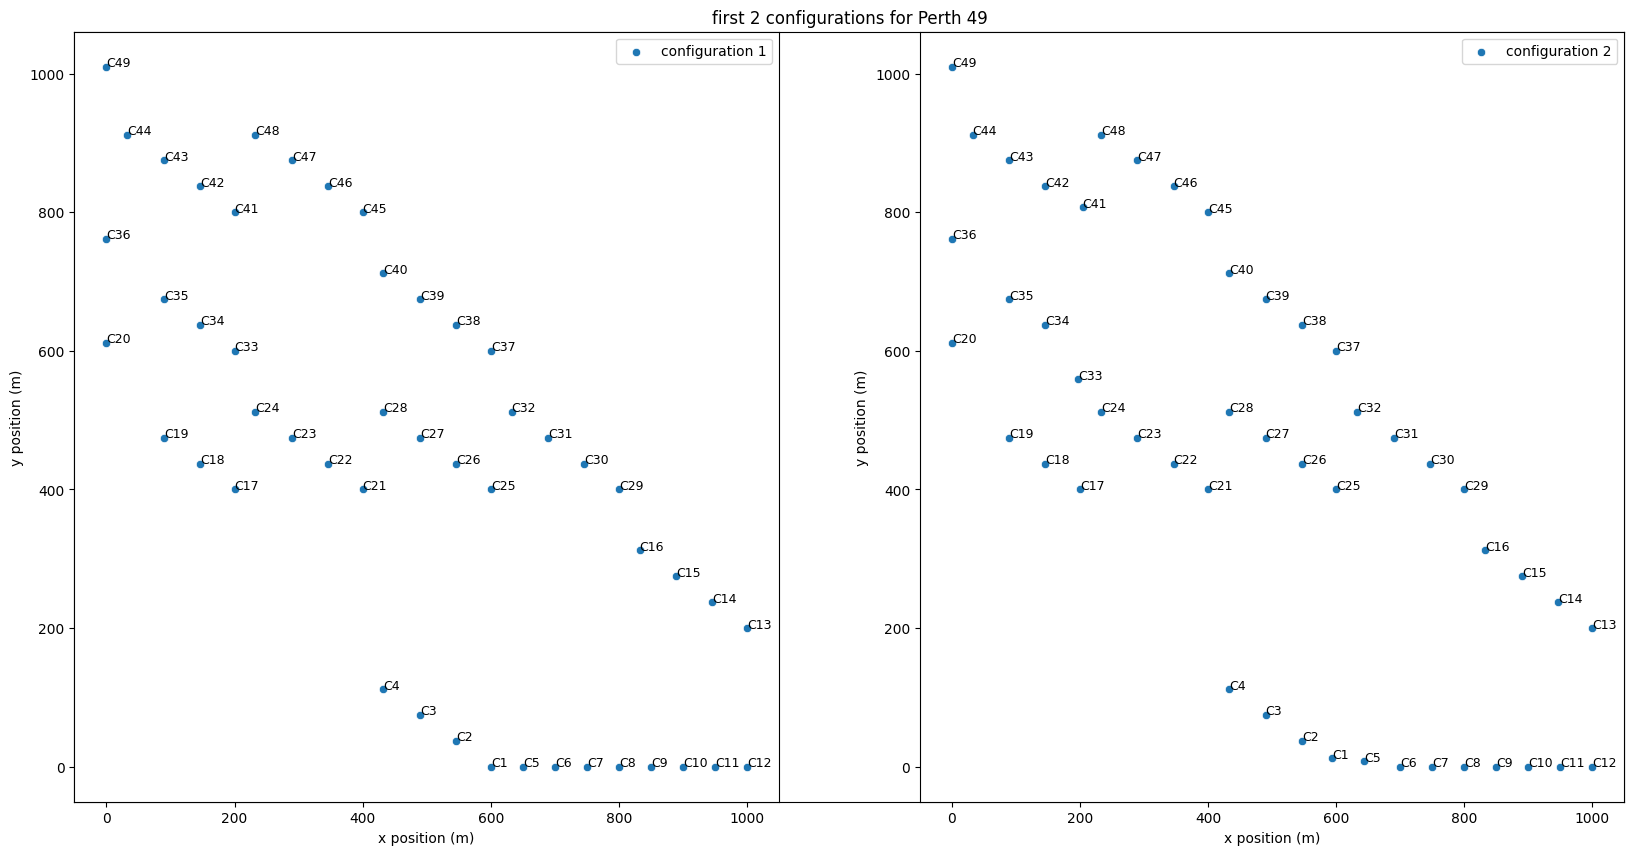

In [16]:
plot_first_n_configurations(perth_49_df, 2, "Perth 49", 2)

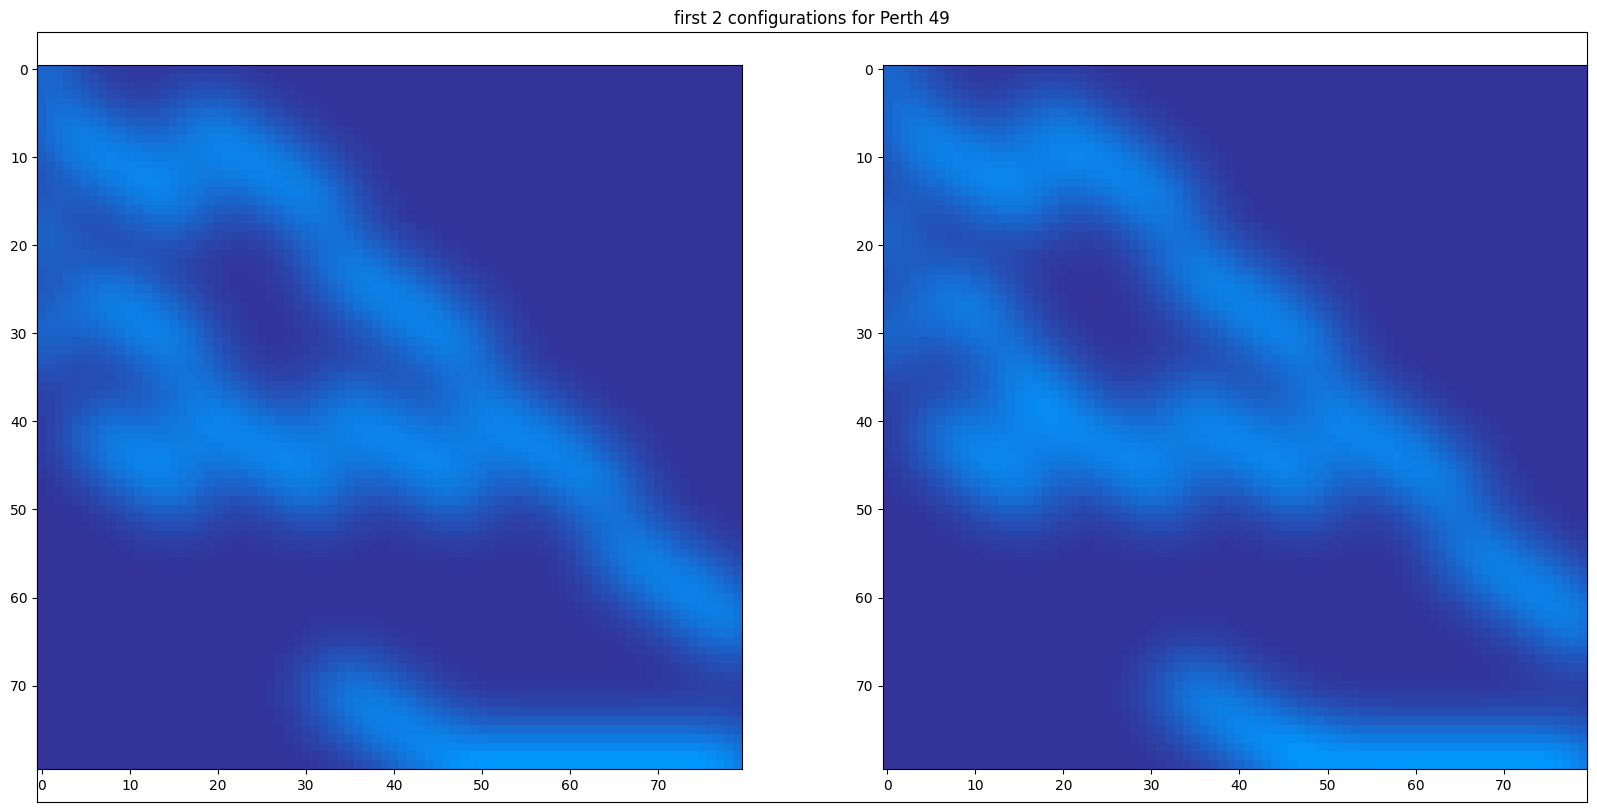

In [17]:
plot_first_n_grid_pictures(X_grid, 2, 'Perth 49', 2)

### Descomposición PCA

Para no trabajar con la matriz completa resultante del proceso de grid, podemos reducir la dimensionalidad del vector de modo que el entrenamiento del modelo de regresión sea más eficiente

In [18]:
def pca_analysis(X, n_comp=None, explained_variance=0.90):
    '''
    Reduces the dimensionality of the grid representation using a PCA analysis
    With a default parameter of 90% of explained variance

    Input: X = the grid representation of the converters locations
           n_comp = number of components to reduce the dimensionality
           explained_variance = percentage of explained variance to keep
    Output: X_pca = the reduced grid representation
    '''
    from sklearn.decomposition import PCA

    if not n_comp:
        n_comp = explained_variance

    pca = PCA(n_components=n_comp)

    return pca.fit_transform(X)

In [ ]:
X_pca = pca_analysis(X_grid)

In [ ]:
X_pca.shape

(36043, 41)

Parece que un valor optimo de componentes es de 41. Tomaremos entonces un valor de 42 para la descomposición de modo que se pueda reajustar las dimensiones del vector a una matrix 7x6 que representen una imagen de dicho tamaño

In [19]:
X_pca = pca_analysis(X_grid, n_comp=42)

In [20]:
X_pca[0,:].reshape(-1,6)

array([[ 21.54304001, -28.12254411,  -6.21155598,  -8.21626119,
         -3.54852925,   2.69164482],
       [  4.63011169, -15.34914042,   2.2673454 ,  -5.3327318 ,
         13.39373853,  -3.37096639],
       [ -7.31659886,   2.84577662,  -2.81806282,   0.63578358,
        -10.11315157,  -8.97895103],
       [ -4.31338057,   0.68613337,  -1.22649932,  -5.24362421,
          1.36262423,  -1.01218835],
       [ -4.2265238 ,  -3.5332278 ,  -0.09762908,  -0.44324275,
         -3.78260556,   0.65524953],
       [  1.90809587,   5.96916908,  -2.5090861 ,  -0.98652463,
          2.77877031,   2.41464585],
       [  0.11981431,  -0.36036853,   1.57121847,  -1.77703097,
         -0.78840998,   0.83623264]])

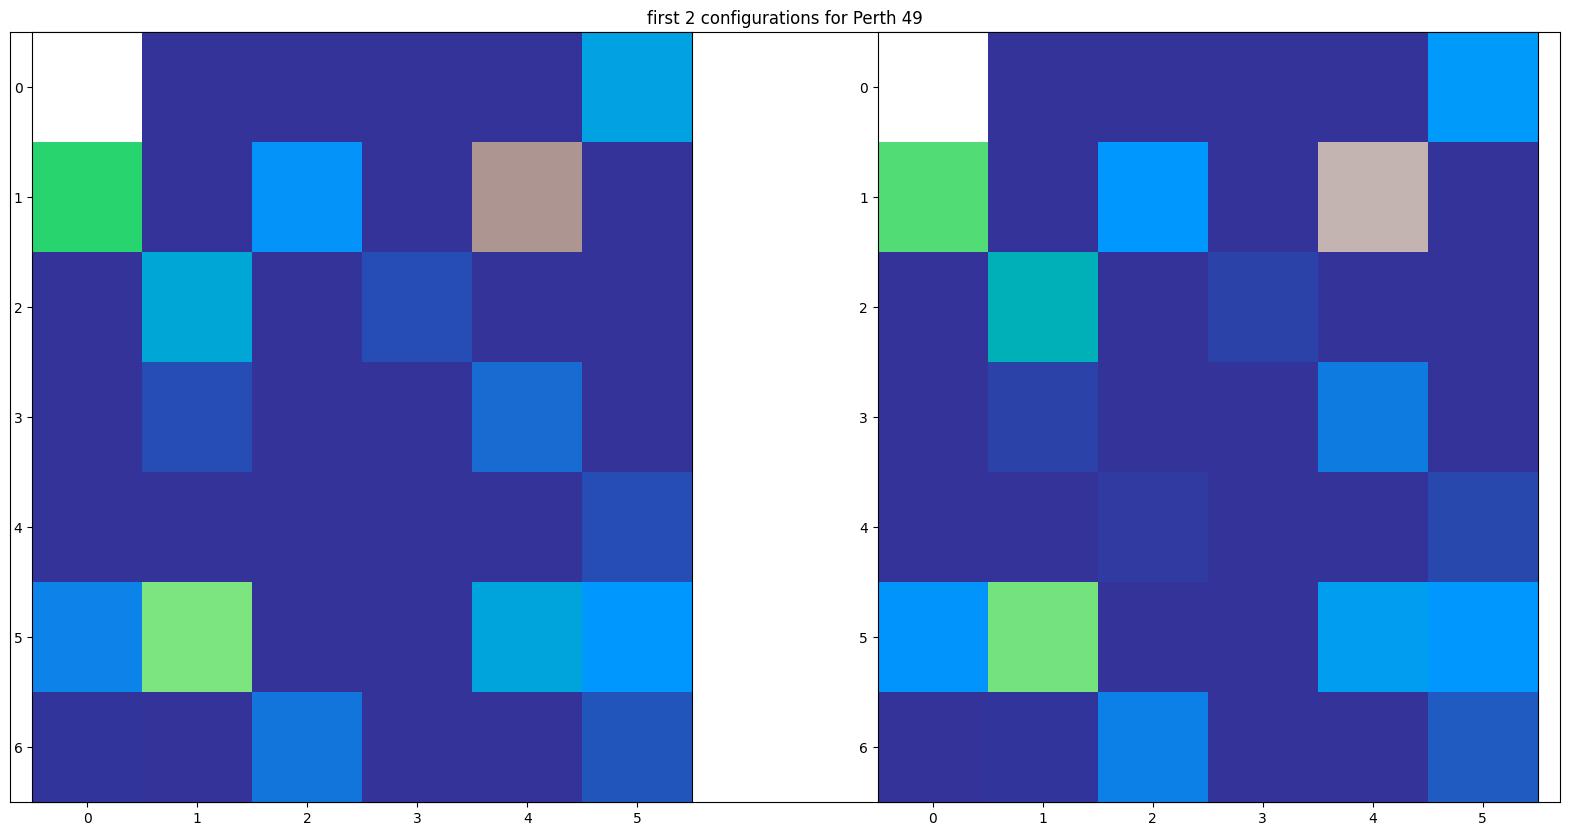

In [22]:
plot_first_n_grid_pictures(X_pca, 2, 'Perth 49', 2)

### Prueba inicial con modelo más simple: Regresión lineal

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

Xtrain, Xtest, ytrain, ytest = train_test_split(X_grid, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

pca = PCA(n_components=42)
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)

In [54]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
R_train = model.score(Xtrain, ytrain)
R_test = model.score(Xtest, ytest)

ytrain_pred = model.predict(Xtrain)
ytest_pred = model.predict(Xtest)

RMSE = root_mean_squared_error(ytrain, ytrain_pred)
MAPE = mean_absolute_percentage_error(ytrain, ytrain_pred)

print(f"R² for train data: {R_train}")
print(f"Root Mean squared error on train data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on train data: {MAPE}")

RMSE = root_mean_squared_error(ytest, ytest_pred)
MAPE = mean_absolute_percentage_error(ytest, ytest_pred)

print(f"R² for test data: {R_test}")
print(f"Root Mean squared error on test data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on test: {MAPE}")

R² for train data: 0.8521460158731937
Root Mean squared error on train data: 0.047202090941704404 MW
Mean absolute percentage error on train data: 0.008728255626920102
R² for test data: 0.8492388733824455
Root Mean squared error on test data: 0.04748099791628865 MW
Mean absolute percentage error on test: 0.00875391324844919


In [55]:
ytrain_pred/10**6 # Representados en MW

array([[3.84179878],
       [3.79412268],
       [3.89245199],
       ...,
       [3.78065203],
       [3.80034839],
       [3.84284205]])

In [56]:
ytrain/10**6 # Representados en MW

array([[3.84084463],
       [3.83705137],
       [3.92190931],
       ...,
       [3.82503367],
       [3.96527033],
       [3.83901813]])

In [57]:
errors = np.abs(ytrain_pred - ytrain)/10**6 # differences in MW
errors

array([[0.00095415],
       [0.04292869],
       [0.02945732],
       ...,
       [0.04438164],
       [0.16492194],
       [0.00382392]])

In [58]:
print(f"Mean error on train data: {np.mean(errors)} \nMax error on train data: {np.max(errors)} \nMin error on train data: {np.min(errors)}")

Mean error on train data: 0.033983700653231703 
Max error on train data: 0.3692939071671022 
Min error on train data: 1.6277996730059385e-07


### Probando invarianza a orden

In [32]:
def layouts_permutation(X):
    '''
    Reorder the layouts in a random way but keeping the same form
    X1, Y1, X2, Y2, ... Xn, Yn

    Input: X = feauture matrix (N x 2*n_converters): coordinates of converters
    Output: X with each layout in some other order
    '''
    if X.shape[1]%2 != 0:
        print('Invalid matrix of features')
        return

    n_converters = X.shape[1]//2

    X_out = np.zeros(X.shape)

    for i in range(X.shape[0]):
        perm = np.random.permutation(n_converters)
        X_out[i, 0:2*n_converters:2] = X[i, perm*2]
        X_out[i, 1:2*n_converters:2] = X[i, perm*2+1]

    return X_out


In [33]:
Xperm = layouts_permutation(X)
print(X[0,0:10])
print(Xperm[0,0:10])

[600.     0.   546.16  37.5  489.79  74.88 432.47 112.05 650.     0.  ]
[432.47 112.05   0.   612.05 146.16 837.5  489.79 474.88 946.16 237.5 ]


In [34]:
Xperm_grid = generate_grid(Xperm)

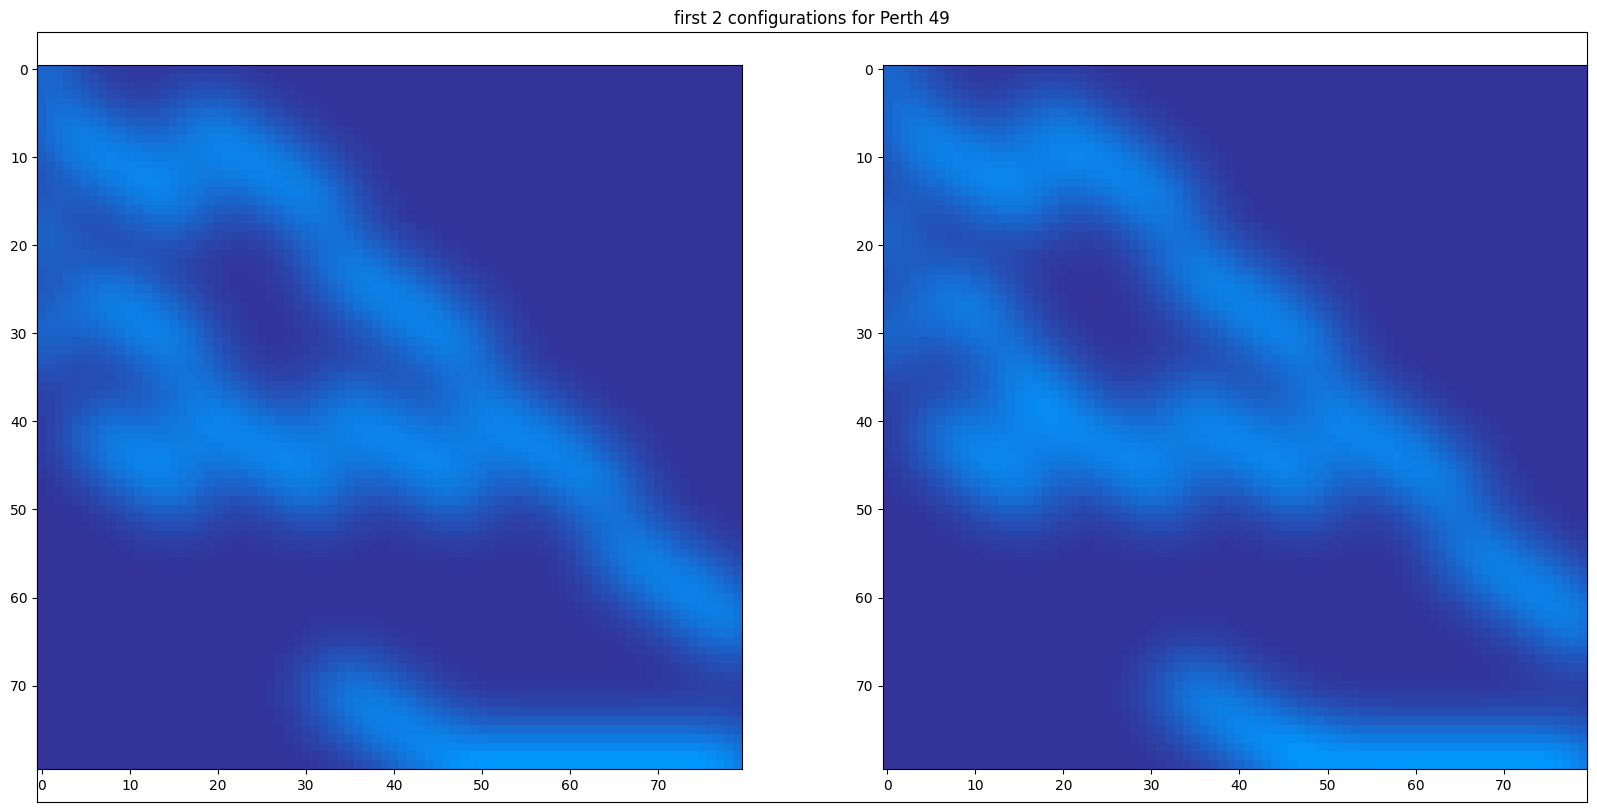

In [35]:
plot_first_n_grid_pictures(Xperm_grid, 2, 'Perth 49', 2)

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

Xtrain, Xtest, ytrain, ytest = train_test_split(Xperm_grid, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

pca = PCA(n_components=42)
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)

In [48]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
R_train = model.score(Xtrain, ytrain)
R_test = model.score(Xtest, ytest)

ytrain_pred = model.predict(Xtrain)
ytest_pred = model.predict(Xtest)

RMSE = root_mean_squared_error(ytrain, ytrain_pred)
MAPE = mean_absolute_percentage_error(ytrain, ytrain_pred)

print(f"R² for train data: {R_train}")
print(f"Root mean squared error on train data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on train data: {MAPE}")

RMSE = root_mean_squared_error(ytest, ytest_pred)
MAPE = mean_absolute_percentage_error(ytest, ytest_pred)

print(f"R² for test data: {R_test}")
print(f"Root mean squared error on test data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on test: {MAPE}")

R² for train data: 0.852071562115013
Mean squared error on train data: 0.04721397405317372 MW
Mean absolute percentage error on train data: 0.00873065911781964
R² for test data: 0.8491985774135401
Mean squared error on test data: 0.047487342937142886 MW
Mean absolute percentage error on test: 0.008755159937989584


In [49]:
ytrain_pred/10**6 # Power in MW

array([[3.84251459],
       [3.79400722],
       [3.8918126 ],
       ...,
       [3.78046156],
       [3.80034814],
       [3.84309873]])

In [50]:
ytrain/10**6 # Power in MW

array([[3.84084463],
       [3.83705137],
       [3.92190931],
       ...,
       [3.82503367],
       [3.96527033],
       [3.83901813]])

In [51]:
errors = np.abs(ytrain_pred - ytrain)/10**6 # differences in MW
errors

array([[0.00166996],
       [0.04304415],
       [0.03009671],
       ...,
       [0.04457211],
       [0.16492219],
       [0.0040806 ]])

In [52]:
print(f"Mean error on train data: {np.mean(errors)} \nMax error on train data: {np.max(errors)} \nMin error on train data: {np.min(errors)}")

Mean error on train data: 0.03399261895087559 
Max error on train data: 0.36858968647664925 
Min error on train data: 4.1305471397936343e-07


### Aleatorizando layouts (Test)

Obtenidas las métricas de error de tan buen desempeño nos preguntamos si el modelo tiene alguna fuga de información o esta vinculando patrones no fisicos de la geometría del layout. Para hacer un test evaluamos que pasaría con el modelo si alteramos las coordenadas de los convertidores de manera aleatoria pero manteniendo la región de posicionamiento dada por la forma de generación del dataset

In [59]:
def randomnize_layouts(X):
    '''
    Generate random positions inside the physical domain of the dataset.
    Keeps shape: (num_samples, 2*N)

    Input: X = feauture matrix (N x 2*n_converters): coordinates of converters
    Output: X with each layout completely different and randomly distributed
    '''
    if X.shape[1]%2 != 0:
        print('Invalid matrix of features')
        return

    n_converters = X.shape[1]//2
    L = np.sqrt(n_converters*20000)

    X_out = np.zeros(X.shape)

    for i in range(X.shape[0]):
        perm = np.random.permutation(n_converters)
        X_out[i, 0::2] = np.random.uniform(0, L, size=n_converters)
        X_out[i, 1::2] = np.random.uniform(0, L, size=n_converters)

    return X_out


In [60]:
X_random= randomnize_layouts(X)

In [61]:
X_random_grid = generate_grid(X_random)

In [62]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_random_grid, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

pca = PCA(n_components=42)
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)

In [63]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
R_train = model.score(Xtrain, ytrain)
R_test = model.score(Xtest, ytest)

ytrain_pred = model.predict(Xtrain)
ytest_pred = model.predict(Xtest)

RMSE = root_mean_squared_error(ytrain, ytrain_pred)
MAPE = mean_absolute_percentage_error(ytrain, ytrain_pred)

print(f"R² for train data: {R_train}")
print(f"Root mean squared error on train data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on train data: {MAPE}")

RMSE = root_mean_squared_error(ytest, ytest_pred)
MAPE = mean_absolute_percentage_error(ytest, ytest_pred)

print(f"R² for test data: {R_test}")
print(f"Root mean squared error on test data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on test: {MAPE}")

R² for train data: 0.0018512814466697947
Root mean squared error on train data: 0.12264288220214814 MW
Mean absolute percentage error on train data: 0.026589995840623597
R² for test data: -0.001332623572075864
Root mean squared error on test data: 0.1223670059107577 MW
Mean absolute percentage error on test: 0.026540370839867357


Notamos que este cambio en la matriz X hace que se pierda todo el desempeño del modelo, El coeficiente de determinación es pésimo  cercano a cero en este caso y el error cuádratico medio aumenta unas tres veces

In [64]:
ytrain_pred/10**6 # Power in MW

array([[3.94283591],
       [3.93915657],
       [3.93884877],
       ...,
       [3.9434528 ],
       [3.94207529],
       [3.94918581]])

In [65]:
ytrain/10**6 # Power in MW

array([[3.84084463],
       [3.83705137],
       [3.92190931],
       ...,
       [3.82503367],
       [3.96527033],
       [3.83901813]])

In [66]:
errors = np.abs(ytrain_pred - ytrain)/10**6 # differences in MW
errors

array([[0.10199128],
       [0.1021052 ],
       [0.01693946],
       ...,
       [0.11841913],
       [0.02319504],
       [0.11016768]])

In [67]:
print(f"Mean error on train data: {np.mean(errors)} \nMax error on train data: {np.max(errors)} \nMin error on train data: {np.min(errors)}")

Mean error on train data: 0.10435272316624272 
Max error on train data: 0.5144659493121109 
Min error on train data: 3.4168734727427366e-07


Ahora probaremos el efecto de alterar las posiciones de cada convertidor de manera aleatoria, es decir, añadiendo un ruido aleatorio no existente en los datos iniciales y probar si el modelo si captura de forma efectiva que el layout, dado por las ubicaciones especificas de cada convertidor es clave en la potencia total generada

In [68]:
def alter_layout_with_noise(X, jitter_scale=0.05):
    """
    Alters the layout configuration of each sample by randomly assigns a small displacement
    in x and y coordinates to each converter given by a random value -jitter_scale*L < dx < jitter_scale*L
    where L = sqrt(N*20000) and N the number of converters. Default value 5% each converter
    will be displaced at a maximum of 50m or 75m in each direction when N=49 and N=100 respectively

    Input:
    X = the original matrix of layouts (N x 2*n_converters): coordinates of converters
    Output
    X_out: Matrix of modified layouts
    """
    if X.shape[1]%2 != 0:
        print('Invalid matrix of features')
        return

    n_converters = X.shape[1]//2
    L = np.sqrt(n_converters*20000)

    X_out = np.zeros(X.shape)

    for i in range(X.shape[0]):
        noise = np.random.normal(-jitter_scale*L, jitter_scale*L, size=2*n_converters)
        X_out[i,:] = X[i,:] + noise

    return X_out


In [69]:
X_random = alter_layout_with_noise(X)

In [70]:
X_random_grid = generate_grid(X_random)

In [71]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_random_grid, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

pca = PCA(n_components=42)
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)

In [72]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
R_train = model.score(Xtrain, ytrain)
R_test = model.score(Xtest, ytest)

ytrain_pred = model.predict(Xtrain)
ytest_pred = model.predict(Xtest)

RMSE = root_mean_squared_error(ytrain, ytrain_pred)
MAPE = mean_absolute_percentage_error(ytrain, ytrain_pred)

print(f"R² for train data: {R_train}")
print(f"Root mean squared error on train data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on train data: {MAPE}")

RMSE = root_mean_squared_error(ytest, ytest_pred)
MAPE = mean_absolute_percentage_error(ytest, ytest_pred)

print(f"R² for test data: {R_test}")
print(f"Root mean squared error on test data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on test: {MAPE}")

R² for train data: 0.6060804664287722
Root mean squared error on train data: 0.07704571324280367 MW
Mean absolute percentage error on train data: 0.01566577486608802
R² for test data: 0.6085554230574564
Root mean squared error on test data: 0.07650860638223082 MW
Mean absolute percentage error on test: 0.015571077744955619


Vemos que el error aumenta con una configuración alterada y el coeficiente de determinación disminuye. El error aumenta al doble apróximadamente con respecto a los layouts originales

In [73]:
ytrain_pred/10**6 # Power in MW

array([[3.78052995],
       [3.81642482],
       [3.87186804],
       ...,
       [3.82422254],
       [3.77609064],
       [3.91493197]])

In [74]:
ytrain/10**6 # Power in MW

array([[3.84084463],
       [3.83705137],
       [3.92190931],
       ...,
       [3.82503367],
       [3.96527033],
       [3.83901813]])

In [75]:
errors = np.abs(ytrain_pred - ytrain)/10**6 # differences in MW
errors

array([[0.06031468],
       [0.02062655],
       [0.05004127],
       ...,
       [0.00081113],
       [0.18917969],
       [0.07591384]])

In [76]:
print(f"Mean error on train data: {np.mean(errors)} \nMax error on train data: {np.max(errors)} \nMin error on train data: {np.min(errors)}")

Mean error on train data: 0.06127550198328479 
Max error on train data: 0.43623630836695015 
Min error on train data: 1.4408037075772881e-06


### Entrenamiento sin procesar (Uso de solo X, y sin procesar ni grid ni PCA)

El modelo previo si captura la información geométrica como factor determinante en la potencia generada tal como se espera y esto con una simple regresión lineal sobre el grid reducido por pca, haciendo esto con una increible precisión. Nos preguntamos que pasaría si aplicamos un modelo de regresión lineal a los datos crudos, es decir, aplicamos la regresión con la matriz original X. En este caso solo aplicamos una normalización inicial a la matriz

In [77]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


In [78]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
R_train = model.score(Xtrain, ytrain)
R_test = model.score(Xtest, ytest)

ytrain_pred = model.predict(Xtrain)
ytest_pred = model.predict(Xtest)

RMSE = root_mean_squared_error(ytrain, ytrain_pred)
MAPE = mean_absolute_percentage_error(ytrain, ytrain_pred)

print(f"R² for train data: {R_train}")
print(f"Root mean squared error on train data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on train data: {MAPE}")

RMSE = root_mean_squared_error(ytest, ytest_pred)
MAPE = mean_absolute_percentage_error(ytest, ytest_pred)

print(f"R² for test data: {R_test}")
print(f"Root mean squared error on test data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on test: {MAPE}")

R² for train data: 0.832346653409068
Root mean squared error on train data: 0.050263281071757274 MW
Mean absolute percentage error on train data: 0.009406145146614179
R² for test data: 0.832842161927418
Root mean squared error on test data: 0.04999637578970712 MW
Mean absolute percentage error on test: 0.009424711641343453


Vemos que los resultados son muy similares a los obtenidos con el modelo que hace procesamiento, demostrando la dependencia de la geometría en la potencia total generada y que además, la relación es muy suave  líneal, lo cual se explica por los modelos matemáticos lineales que se han aplicado para los calculos de potencia.

### Que pasa si se reordenan los datos

La matriz original tiene un orden implicito, si aplicamos un reordenamiento a los datos y aplicamos el modelo sin procesamiento lo que se espera es que el modelo falle, pues los datos originales traen dicho ordenamiento arbitrario, el cual no debe de influir en la potencia inicial pues siguen siendo el mismo conjunto de coordenadas

In [79]:
X_random = layouts_permutation(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_random, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [80]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
R_train = model.score(Xtrain, ytrain)
R_test = model.score(Xtest, ytest)

ytrain_pred = model.predict(Xtrain)
ytest_pred = model.predict(Xtest)

RMSE = root_mean_squared_error(ytrain, ytrain_pred)
MAPE = mean_absolute_percentage_error(ytrain, ytrain_pred)

print(f"R² for train data: {R_train}")
print(f"Root mean squared error on train data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on train data: {MAPE}")

RMSE = root_mean_squared_error(ytest, ytest_pred)
MAPE = mean_absolute_percentage_error(ytest, ytest_pred)

print(f"R² for test data: {R_test}")
print(f"Root mean squared error on test data: {RMSE/10**6} MW") # In MW
print(f"Mean absolute percentage error on test: {MAPE}")

R² for train data: 0.07409342191609569
Root mean squared error on train data: 0.11812132399264054 MW
Mean absolute percentage error on train data: 0.02532611261325091
R² for test data: 0.06450682172199274
Root mean squared error on test data: 0.1182756826598148 MW
Mean absolute percentage error on test: 0.025362559199506238


Observamos nuevamente que el coeficiente de determinación cae a un nivel cercano a cero y la raiz del error cuadrático medio aumenta unas tres veces. Esto demuestra que el procesamiento logra eliminar la dependencia del orden arbitrario (invarianza de enumeración) y captura la geometría del problema como el factor determinante en la potencia total generada. Las ventajas del modelo propuesto es una gran generalización, puesto que la información original se transforma a una imagen de 80x80 pixeles, en dicha imagen es posible representar el posicionamiento de cualquier numero de convertidores y de esta manera combinar los datos con N=49 y N=100, asi como también ofrecer prediciones para otros valores de N